Basic Chatbot with using Langgrapht(Graph API)

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [9]:
class State(TypedDict):
    messages:Annotated[list,add_messages]


graph_builder=StateGraph(State)

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000023B007A0050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023B007A0D70>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
#ANother approach
# llm=init_chat_model("groq:llama3-8b")

In [7]:
#Node functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder=StateGraph(State)

#adding node
graph_builder.add_node("llmchatbot",chatbot)
#adding edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

#compile the graph
graph=graph_builder.compile()



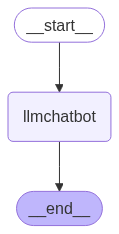

In [9]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response=graph.invoke({"messages":"Do you know lionel Messi?"})

In [11]:
response["messages"][-1].content

"Lionel Messi is a world-renowned Argentine professional footballer who is widely regarded as one of the greatest players of all time. He is known for his exceptional dribbling skills, speed, and goal-scoring ability.\n\nMessi has played for FC Barcelona and the Argentina national team throughout his career. He has won numerous accolades, including six Ballon d'Or awards, ten La Liga titles, and four UEFA Champions League titles. He has also broken numerous records in the sport, including the most goals scored in La Liga and the most assists in the UEFA Champions League.\n\nMessi is known for his incredible vision, creativity, and ability to score goals from almost anywhere on the field. He is also known for his humility and kindness off the field, often using his platform to support charitable causes and bring attention to social issues.\n\nSome of his most notable achievements include:\n\n* Scoring over 770 goals for club and country\n* Winning the Ballon d'Or a record-breaking seven

In [12]:
for event in graph.stream({"messages":"Hello, How are you"}):
    for val in event.values():
        print(val["messages"][-1].content)
    

Hello! I'm just an AI, so I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?


# ChatBot using Tool

In [1]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [19]:
##Custom function

def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int: output int
    """

    return a*b

In [20]:
tools=[tool,multiply]

In [21]:
llm_with_tool = llm.bind_tools(tools)

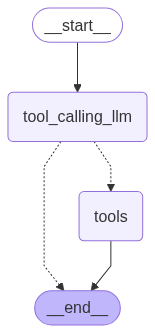

In [22]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Add edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
     
)

builder.add_edge("tools",END)

#compile the graph


graph = builder.compile()

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# response=graph.invoke({"messages":"What is 5 multiply by 2"})
response=graph.invoke({"messages":"Give me the recent ai news and then answerWhat is 5 multiply by 2"})
# response 

{'messages': [HumanMessage(content='Give me the recent ai news and then answerWhat is 5 multiply by 2', additional_kwargs={}, response_metadata={}, id='536a88b8-1dfd-40e1-96aa-1d006374bee8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'z9nyxtvae', 'function': {'arguments': '{"query":"recent ai news","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 273, 'prompt_tokens': 2273, 'total_tokens': 2546, 'completion_time': 0.342884234, 'prompt_time': 0.379250482, 'queue_time': 0.051823167999999975, 'total_time': 0.722134716}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--222b78c0-cd85-4d40-b494-b884f42983b9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent ai news', 'search_depth': 'advanced', 'topic': 'news'}, 'id': 'z9nyxtvae', 'type': 'tool_c

In [27]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/amazon-ai-ambitions-commerce-giant-surpass-nvidia-microsoft-valuation-2030-2507/", "title": "Amazon\'s AI Ambitions: Why the E-commerce Giant Could Surpass Nvidia and Microsoft in Valuation by 2030 - AInvest", "score": 0.69795954, "published_date": "Sun, 13 Jul 2025 01:00:44 GMT", "content": "Amazon\'s AI business has achieved a multi-billion-dollar annual run rate with triple-digit growth rates, positioning Amazon advantageously in the generative AI transformation sweeping through enterprise technology . Recent AWS developments demonstrate the company\'s commitment to AI leadership, including the introduction of Amazon Nova Canvas with AI-powered image generation capabilities and the availability of Anthropic Claude 4 models through Amazon Bedrock .", "raw_content": null}, {"url": "https://www.csoonline.com/article/4021749/new-grok-4-ai-breached-wit

In [28]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then answerWhat is 5 multiply by 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (z9nyxtvae)
 Call ID: z9nyxtvae
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/amazon-ai-ambitions-commerce-giant-surpass-nvidia-microsoft-valuation-2030-2507/", "title": "Amazon's AI Ambitions: Why the E-commerce Giant Could Surpass Nvidia and Microsoft in Valuation by 2030 - AInvest", "score": 0.69795954, "published_date": "Sun, 13 Jul 2025 01:00:44 GMT", "content": "Amazon's AI business has achieved a multi-billion-dollar annual run rate with triple-digit growth rate

# ReACT Agent Architecture

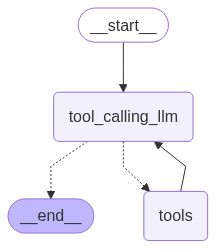

In [29]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Add edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
     
)

builder.add_edge("tools","tool_calling_llm") # Instead going to tools--> End its going to tool_calling_llm

#compile the graph


graph = builder.compile()

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))


In [30]:
# response=graph.invoke({"messages":"What is 5 multiply by 2"})
response=graph.invoke({"messages":"Give me the recent ai news and then answerWhat is 5 multiply by 2"})
# response 

In [31]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then answerWhat is 5 multiply by 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (bhqczhf0k)
 Call ID: bhqczhf0k
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://medium.com/@anirudhsekar2008/the-ai-world-just-shifted-again-9-stories-you-need-to-know-july-2025-474a3ec7e86c", "title": "The AI World Just Shifted Again — 9 Stories You Need to Know (July ...", "content": "# 2. xAI Wins Controversial $200 Million Defense Contract\n\nElon Musk’s company xAI, makers of the Grok chatbot, has landed a $200 million defense contract to integrate Grok’s models into U.S. federal ag

# Adding Memory In Agentic Graph

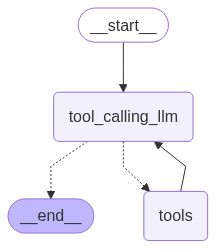

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Node Defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Add edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
     
)

builder.add_edge("tools","tool_calling_llm") # Instead going to tools--> End its going to tool_calling_llm

#compile the graph


graph = builder.compile(checkpointer=memory)

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))


In [51]:
config= {"configurable":{"thread_id":"2"}}

response = graph.invoke({"messages":"Hey My name is Jishnu"},config=config)

response

{'messages': [HumanMessage(content='Hey My name is Jishnu', additional_kwargs={}, response_metadata={}, id='0914ada2-9365-4776-9dfe-5ed43b5463c3'),
  AIMessage(content='Nice to meet you, Jishnu!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 2263, 'total_tokens': 2273, 'completion_time': 0.013438015, 'prompt_time': 0.31355655, 'queue_time': 0.06004209100000002, 'total_time': 0.326994565}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--11bdc51c-33f2-4117-a1f7-3cf7630b8dea-0', usage_metadata={'input_tokens': 2263, 'output_tokens': 10, 'total_tokens': 2273})]}

In [47]:
response["messages"][-1].content

'Nice to meet you, Jishnu! What brings you here today?'

In [52]:
response = graph.invoke({"messages":"Hey do you remember my name?"},config=config)

print(response["messages"][-1].content)

I'm happy to help! However, I'm a new AI model, and we just started our conversation, so I don't have any information about your name yet. But please feel free to introduce yourself, and I'll do my best to remember it for our conversation!


# Streaming

# Human Feedback